In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [4]:
import pandas as pd
stock_df=pd.read_csv('MSFT.csv')
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063504,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061888,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400
...,...,...,...,...,...,...,...
9515,2023-12-13,376.019989,377.640015,370.769989,374.369995,374.369995,30955500
9516,2023-12-14,373.309998,373.760010,364.130005,365.929993,365.929993,43277500
9517,2023-12-15,366.850006,372.399994,366.279999,370.730011,370.730011,78478200
9518,2023-12-18,369.450012,373.000000,368.679993,372.649994,372.649994,21802900


In [5]:
stock_df = stock_df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
stock_df.head()

,date,open,high,low,close,adj_close,volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063504,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061888,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400


In [6]:
print("Total number of days: ",stock_df.shape[0])
print("Total number of fields: ",stock_df.shape[1])

Total number of days:  9520
Total number of fields:  7


In [7]:
print("Null values:", stock_df.isnull().values.sum())

print("NA values:", stock_df.isna().values.any())

Null values: 0
NA values: False


In [8]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9520 entries, 0 to 9519
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       9520 non-null   object 
 1   open       9520 non-null   float64
 2   high       9520 non-null   float64
 3   low        9520 non-null   float64
 4   close      9520 non-null   float64
 5   adj_close  9520 non-null   float64
 6   volume     9520 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 520.8+ KB


In [9]:
stock_df['date'] = pd.to_datetime(stock_df['date'], utc=True)

In [10]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9520 entries, 0 to 9519
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       9520 non-null   datetime64[ns, UTC]
 1   open       9520 non-null   float64            
 2   high       9520 non-null   float64            
 3   low        9520 non-null   float64            
 4   close      9520 non-null   float64            
 5   adj_close  9520 non-null   float64            
 6   volume     9520 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 520.8 KB


In [11]:
print("Starting date: ",stock_df.iloc[0][0])

print("Ending date: ", stock_df.iloc[-1][0])

print("Duration: ", stock_df.iloc[-1][0]-stock_df.iloc[0][0])

Starting date:  1986-03-13 00:00:00+00:00
Ending date:  2023-12-19 00:00:00+00:00
Duration:  13795 days 00:00:00


In [12]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(stock_df, x=stock_df.date, y=[stock_df['open'], stock_df['close'],
                                          stock_df['high'], stock_df['low']],
             labels={'date': 'Date','value':'Stock value'})

fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

In [13]:
stock_df_close = stock_df[['date','close']]

print("Shape of close dataframe:", stock_df_close.shape)

Shape of close dataframe: (9520, 2)


In [14]:
stock_df_close_last_1_year = stock_df_close[stock_df_close['date'] > '2021-10-03']

stock_df_close_last_1_year_original_gt = stock_df_close_last_1_year.copy()

print("Total data for prediction: ",stock_df_close_last_1_year.shape[0])

Total data for prediction:  557


In [15]:
fig = px.line(stock_df_close_last_1_year, x=stock_df_close_last_1_year.date, y=stock_df_close_last_1_year.close,labels={'date':'Date','close':'Close Stock'})

fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')

fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

In [16]:
training_size=int(len(stock_df_close_last_1_year)*0.80)

test_size=len(stock_df_close_last_1_year)-training_size

train_data,test_data = stock_df_close_last_1_year[0:training_size], stock_df_close_last_1_year[training_size:len(stock_df_close_last_1_year)]

print("train_data: ", train_data.shape)  # (201, 2)

print("test_data: ", test_data.shape) # (51, 2)

train_data:  (445, 2)
test_data:  (112, 2)


In [17]:
del train_data['date']

del test_data['date']

In [18]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(train_data.shape) # (201, 1)

(445, 1)


In [19]:
def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
time_step = 15

X_train, y_train = create_sliding_window(train_data, time_step)

X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (429, 15)
y_train:  (429,)
X_test:  (96, 15)
y_test (96,)


In [21]:
X_train =X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (429, 15, 1)
X_test:  (96, 15, 1)


In [22]:
model=Sequential()

model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))

model.add(GRU(32,return_sequences=True))

model.add(GRU(32))

model.add(Dropout(0.20))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16065 (62.75 KB)
Trainable params: 16065 (62.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
14/14 [==============================] - 8s 111ms/step - loss: 0.0852 - val_loss: 0.0089
Epoch 2/200
14/14 [==============================] - 0s 23ms/step - loss: 0.0251 - val_loss: 0.0656
Epoch 3/200
14/14 [==============================] - 0s 25ms/step - loss: 0.0152 - val_loss: 0.0083
Epoch 4/200
14/14 [==============================] - 0s 23ms/step - loss: 0.0101 - val_loss: 0.0060
Epoch 5/200
14/14 [==============================] - 0s 24ms/step - loss: 0.0086 - val_loss: 0.0098
Epoch 6/200
14/14 [==============================] - 0s 25ms/step - loss: 0.0085 - val_loss: 0.0037
Epoch 7/200
14/14 [==============================] - 0s 23ms/step - loss: 0.0074 - val_loss: 0.0035
Epoch 8/200
14/14 [==============================] - 0s 24ms/step - loss: 0.0073 - val_loss: 0.0036
Epoch 9/200
14/14 [==============================] - 0s 26ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 10/200
14/14 [==============================] - 0s 24ms/step - loss: 0.0074 - val_loss: 0.002

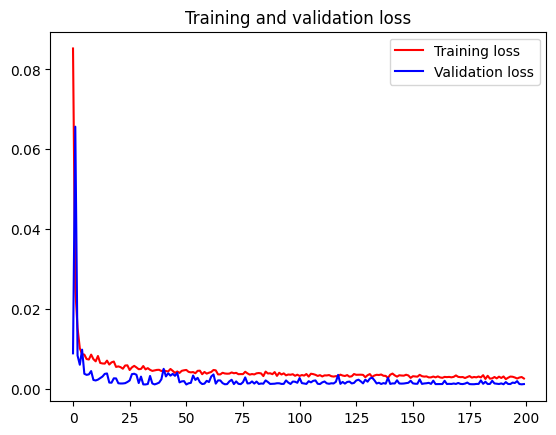

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')

plt.legend(loc=0)

plt.figure()


plt.show()

In [26]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)

test_predict=model.predict(X_test)

train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 7ms/step


((429, 1), (96, 1))

In [27]:
train_predict = scaler.inverse_transform(train_predict)

test_predict = scaler.inverse_transform(test_predict)

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))

original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [28]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict)))

print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))

print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("-------------------------------------------------------------------------------------")

print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))

print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  5.708913905410618
Train data MSE:  32.59169797939072
Train data MAE:  4.484449110542777
-------------------------------------------------------------------------------------
Test data RMSE:  4.540984186775126
Test data MSE:  20.620537384541752
Test data MAE:  3.616656580485023


In [29]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))

print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9731512615696365
Test data explained variance regression score: 0.9590403668156775


In [30]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9719970215049337
Test data R2 score: 0.9568632804323725


In [31]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))

print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")

print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))

print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0004417219719408065
Test data MGD:  0.00017676736202688892
----------------------------------------------------------------------
Train data MPD:  0.11923483531062161
Test data MPD:  0.06027243894528311


In [32]:
# shift train predictions for plotting the look-ahead time for predicted stock values

# First delete the 'date' column from below df to make it a single column df
# so that train_predict_look_ahead variable can be properly structured
del stock_df_close_last_1_year['date']

look_back=time_step

train_predict_look_ahead = np.empty_like(stock_df_close_last_1_year)

train_predict_look_ahead[:, :] = np.nan

# For looking ahead by look_back, I need to start at look_back
train_predict_look_ahead[look_back:len(train_predict)+look_back, :] = train_predict

print("Train predicted data: ", train_predict_look_ahead.shape)

####################### TEST #############################
# shift test predictions for plotting
test_predict_look_ahead = np.empty_like(stock_df_close_last_1_year)

test_predict_look_ahead[:, :] = np.nan

test_predict_look_ahead[len(train_predict)+(look_back*2)+1:len(stock_df_close_last_1_year)-1, :] = test_predict

print("Test predicted data: ", test_predict_look_ahead.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': stock_df_close_last_1_year_original_gt['date'],
                       'original_close': stock_df_close_last_1_year_original_gt['close'],
                      'train_predicted_close': train_predict_look_ahead.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': test_predict_look_ahead.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})

fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (557, 1)
Test predicted data:  (557, 1)


In [33]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1) # time_step is 15
print("x_input.shape ", x_input.shape)
print("x_input", x_input)

print('###########################################################################')

temp_input=list(x_input)
print(temp_input)

x_input.shape  (1, 15)
x_input [[1.22973477 1.23018302 1.19731044 1.15719095 1.1824429  1.15465059
  1.17071352 1.19521856 1.17332821 1.19633917 1.19626438 1.13320871
  1.16906988 1.18341417 1.18797163]]
###########################################################################
[array([1.22973477, 1.23018302, 1.19731044, 1.15719095, 1.1824429 ,
       1.15465059, 1.17071352, 1.19521856, 1.17332821, 1.19633917,
       1.19626438, 1.13320871, 1.16906988, 1.18341417, 1.18797163])]


In [34]:
temp_input=temp_input[0].tolist()
len(temp_input)

15

In [35]:
from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        y_pred = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,y_pred))
        temp_input.extend(y_pred[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(y_pred.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1)) # Reshape x_input to a 3D Tensor [samples, time steps, features] before feeding into the model
        y_pred = model.predict(x_input, verbose=0)
        temp_input.extend(y_pred[0].tolist())

        lst_output.extend(y_pred.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [36]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [37]:
temp_matrix = np.empty((len(last_days)+pred_days+1, 1))

temp_matrix[:] = np.nan

temp_matrix

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [38]:
temp_matrix.shape

(46, 1)

In [39]:
temp_matrix = temp_matrix.reshape(1,-1).tolist()[0]

In [40]:
last_original_days_value = temp_matrix

next_predicted_days_value = temp_matrix

last_original_days_value[0:time_step+1] = stock_df_close_last_1_year_original_gt[len(stock_df_close_last_1_year_original_gt)-time_step:]['close'].tolist()

next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

In [41]:
last_original_days_value[0:time_step+1]

[378.850006,
 378.910004,
 374.51001,
 369.140015,
 372.519989,
 368.799988,
 370.950012,
 374.230011,
 371.299988,
 374.380005,
 374.369995,
 365.929993,
 370.730011,
 372.649994,
 373.26001,
 nan]

In [42]:
next_predicted_days_value[time_step+1:]

[371.9994358323283,
 370.62331241382265,
 369.3292355912304,
 368.0959517539415,
 366.91304152678464,
 365.7749840769736,
 364.67802970594,
 363.61806172334025,
 362.5912666059494,
 361.594708419569,
 360.6260416080732,
 359.68344716875214,
 358.7656805208044,
 357.87143325877184,
 356.99968418815087,
 356.1495078514223,
 355.3200426157236,
 354.510538541341,
 353.7202456885609,
 352.9484460299978,
 352.19448536292265,
 351.4577573530988,
 350.73765566628975,
 350.0336537490794,
 349.34519313572355,
 348.67177918513437,
 348.01293321238825,
 347.3682164229718,
 346.7371820442897,
 346.1194471284029]

In [43]:
len(last_original_days_value[0:time_step+1])

16

In [44]:
len(next_predicted_days_value[time_step+1:])

30

In [45]:
new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

new_pred_plot.tail()

,last_original_days_value,next_predicted_days_value
41,348.671779,348.671779
42,348.012933,348.012933
43,347.368216,347.368216
44,346.737182,346.737182
45,346.119447,346.119447


In [46]:
new_pred_plot.shape

(46, 2)

In [47]:
names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'], new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})

fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(visible=True, name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

In [59]:
# Convert stock_df_close_last_1_year to np.array
# Otherwise tolist() method can not be applied to them
stock_df_close_last_1_year = np.array(stock_df_close_last_1_year)

lstmdf=stock_df_close_last_1_year.tolist()

lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())

lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})

fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()